# Flights_Networkx(clone)
**201823871 박지헌**

## 0. Setting

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines


In [4]:
pd.set_option("max_rows", 5)
pd.set_option("max_columns", None)

## 1. 데이터 전처리

### 1.1. 지리적 정보를 포함하는 airport_us

In [5]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
                   'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                            names = airport_col, index_col = 0)
airport_df

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports
14110,Melitopol Air Base,Melitopol,Ukraine,\N,UKDM,46.880001,35.305000,0,\N,\N,\N,airport,OurAirports


In [6]:
airport_us = airport_df[(airport_df.Country == "United States") & (airport_df.Lat > 25) & (airport_df.Lat < 50) & (airport_df.Long > -130) & (airport_df.Long < -60)]
airport_us

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
3416,Orlando Executive Airport,Orlando,United States,ORL,KORL,28.545500,-81.332901,113,-5,A,America/New_York,airport,OurAirports
3425,Laurence G Hanscom Field,Bedford,United States,BED,KBED,42.470001,-71.289001,133,-5,A,America/New_York,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13759,Oswego County Airport,Fulton,United States,\N,KFZY,43.350800,-76.388100,475,-4,A,\N,airport,OurAirports
13803,Mitchell Municipal Airport,Mitchell,United States,MHE,KMHE,43.774799,-98.038597,1304,-6,A,\N,airport,OurAirports


In [7]:
#미국라인 인덱스
us_airport_ix = airport_us.index.values
us_airport_ix

array([ 3416,  3425,  3432, ..., 13758, 13759, 13803], dtype=int64)

### 1.2. 항공 경로를 포함하는 routes_us


In [8]:
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
                  'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                            names = route_cols)
routes_df

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734
67662,ZM,19016,OSS,2913,FRU,2912,NaN,0,734


In [9]:
routes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Airline            67663 non-null  object
 1   Airline ID         67663 non-null  object
 2   Source Airport     67663 non-null  object
 3   Source Airport ID  67663 non-null  object
 4   Dest Airport       67663 non-null  object
 5   Dest Airport ID    67663 non-null  object
 6   Codeshare          14597 non-null  object
 7   Stops              67663 non-null  int64 
 8   equipment          67645 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.6+ MB


In [10]:
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 
routes_df

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410,ASF,2966.0,KZN,2990.0,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67661,ZM,19016,FRU,2912.0,OSS,2913.0,NaN,0,734
67662,ZM,19016,OSS,2913.0,FRU,2912.0,NaN,0,734


In [11]:
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) & (routes_df['Dest Airport ID'].isin(us_airport_ix))]
#extract routes that flyies from AND to USA
#출발지 - 목적지 미국라인 
routes_us

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
260,3E,10739,BRL,5726.0,ORD,3830.0,NaN,0,CNC
261,3E,10739,BRL,5726.0,STL,3678.0,NaN,0,CNC
...,...,...,...,...,...,...,...,...,...
67569,ZK,2607,VIS,7121.0,LAX,3484.0,NaN,0,BE1
67570,ZK,2607,WRL,5777.0,CYS,3804.0,NaN,0,BEH BE1


In [12]:
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns
routes_us

,Source Airport,Dest Airport,counts
0,ABE,ATL,3
1,ABE,CLT,2
...,...,...,...
4946,YUM,LAX,1
4947,YUM,PHX,2


* 각 행이 고유한 항공 경로를 나타내는 압축 된 경로 데이터 프레임
* counts: 해당 경로에서 운항하는 총 항공사 수
* ABE에서 ATL까지의 항공편을 운항하는 3개의 항공사가 있다.

### 1.3. 둘을 압축하여 위치를 나타내는 pos_data
* counts: 이름을 기준으로 압축하여 counts 총합

In [13]:
counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
counts

,IATA,total_flight
ATL,ATL,301
ORD,ORD,289
...,...,...
CDC,CDC,2
PAH,PAH,2


* pos_data: 압축된 counts 데이터 프레임에 IATA를 기준으로 airport_us와 merge

In [14]:
pos_data = counts.merge(airport_us, on = 'IATA')
pos_data

,IATA,total_flight,Name,City,Country,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
0,ATL,301,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports
1,ORD,289,Chicago O'Hare International Airport,Chicago,United States,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,CDC,2,Cedar City Regional Airport,Cedar City,United States,KCDC,37.701000,-113.098999,5622,-7,A,America/Denver,airport,OurAirports
402,PAH,2,Barkley Regional Airport,PADUCAH,United States,KPAH,37.060799,-88.773804,410,-6,A,America/Chicago,airport,OurAirports


* 각 행이 IATA 코드로 각 미국 공항을 나타내는 **위치** 데이터 프레임

## 2. 그래프 그리기

### 2.1. 네트워크 그래프
* 데이터 프레임을 방향성이 있는 그래프로 변환
| Keyword | Description |
|-------|-----|
| edge_attr | 그래프의 모서리에 정보추가, 노선에서 운항하는 항공사의 수 |


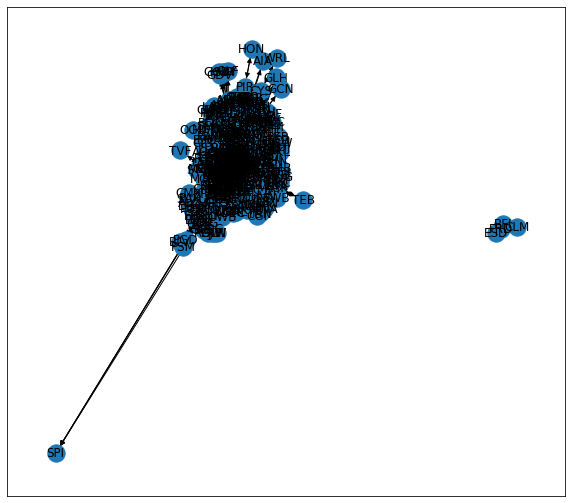

In [15]:
# Create graph
graph = nx.from_pandas_edgelist(
    routes_us,
    source = 'Source Airport',
    target = 'Dest Airport',
    edge_attr = 'counts',
    create_using = nx.DiGraph())

# default graph using Networkx inbuilt graph tools
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.savefig("data/output/networkx_basemap1.png", format = "png", dpi = 300)
plt.show()


* 유의미한 결과를 도출하기 힘들다

### 2.2. basemap을 이용한 네트워크 그래프
* 각각 노드의 네트워크 관계는 미리 만들어둔 graph에, basemap은 pos_data에 있는 지리적 위치를 이용해 지도 시각화
* Basemap함수 Parameter
| Keyword | Description |
|-------|-----|
| longitude | 경도(세로) |
| latitude | 위도(가로) |
| **ll**crnr**lon** | longitude of lower left |
| **ll**crnr**lat** | latitude of lower left |
| **ur**crnr**lon** | longitude of upper right |
| **ur**crnr**lat** | latitude of upper right |



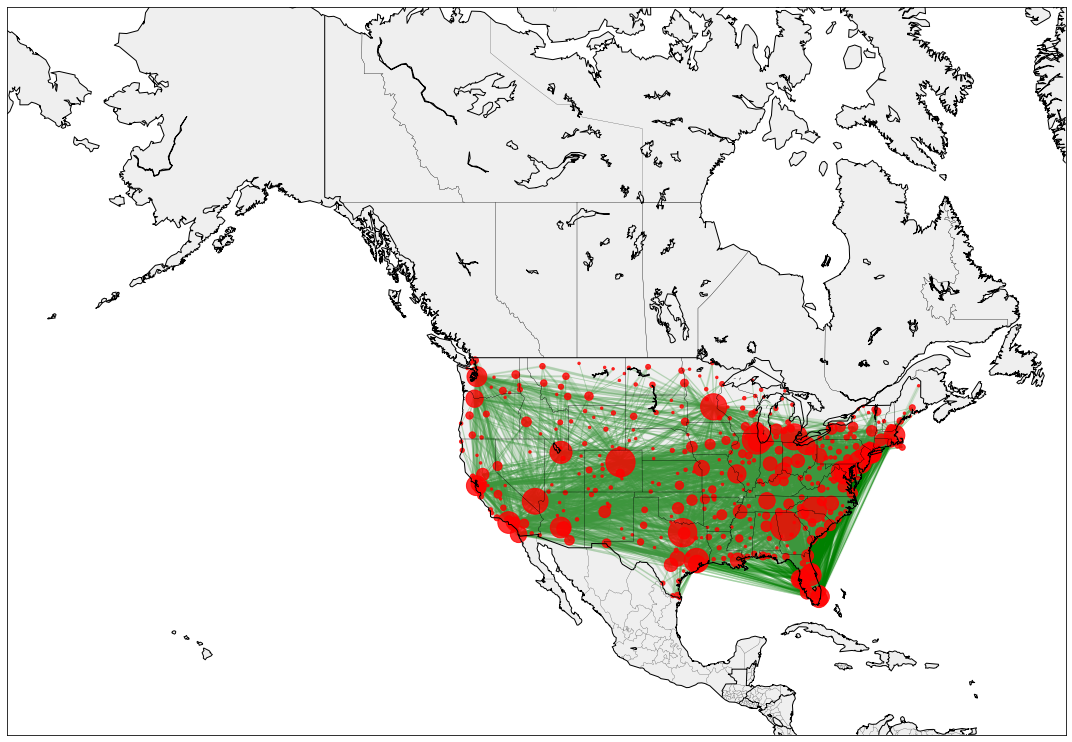

In [16]:
# import long lat as m attribute
plt.figure(figsize = (15,20))
m = Basemap(
    projection='merc',
    llcrnrlon=-180,
    llcrnrlat=10,
    urcrnrlon=-50,
    urcrnrlat=70,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

# import long lat as m attribute
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])


#draw nodes and edges and over aly on basemap
# nodes
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = graph.nodes(),
    node_color = 'r',
    alpha = 0.8,
    node_size = [counts['total_flight'][s]*3 for s in graph.nodes()])
# edges
nx.draw_networkx_edges(
    G = graph,
    pos = pos,
    edge_color='g',
    width = routes_us['counts']*0.75,
    alpha=0.2,
    arrows = False)

m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(alpha = 0.3)
plt.tight_layout()
plt.savefig("data/output/networkx_basemap2.png", format = "png", dpi = 300)
plt.show()

### 2.3. basemap을 이용한 네트워크 그래프 세분화

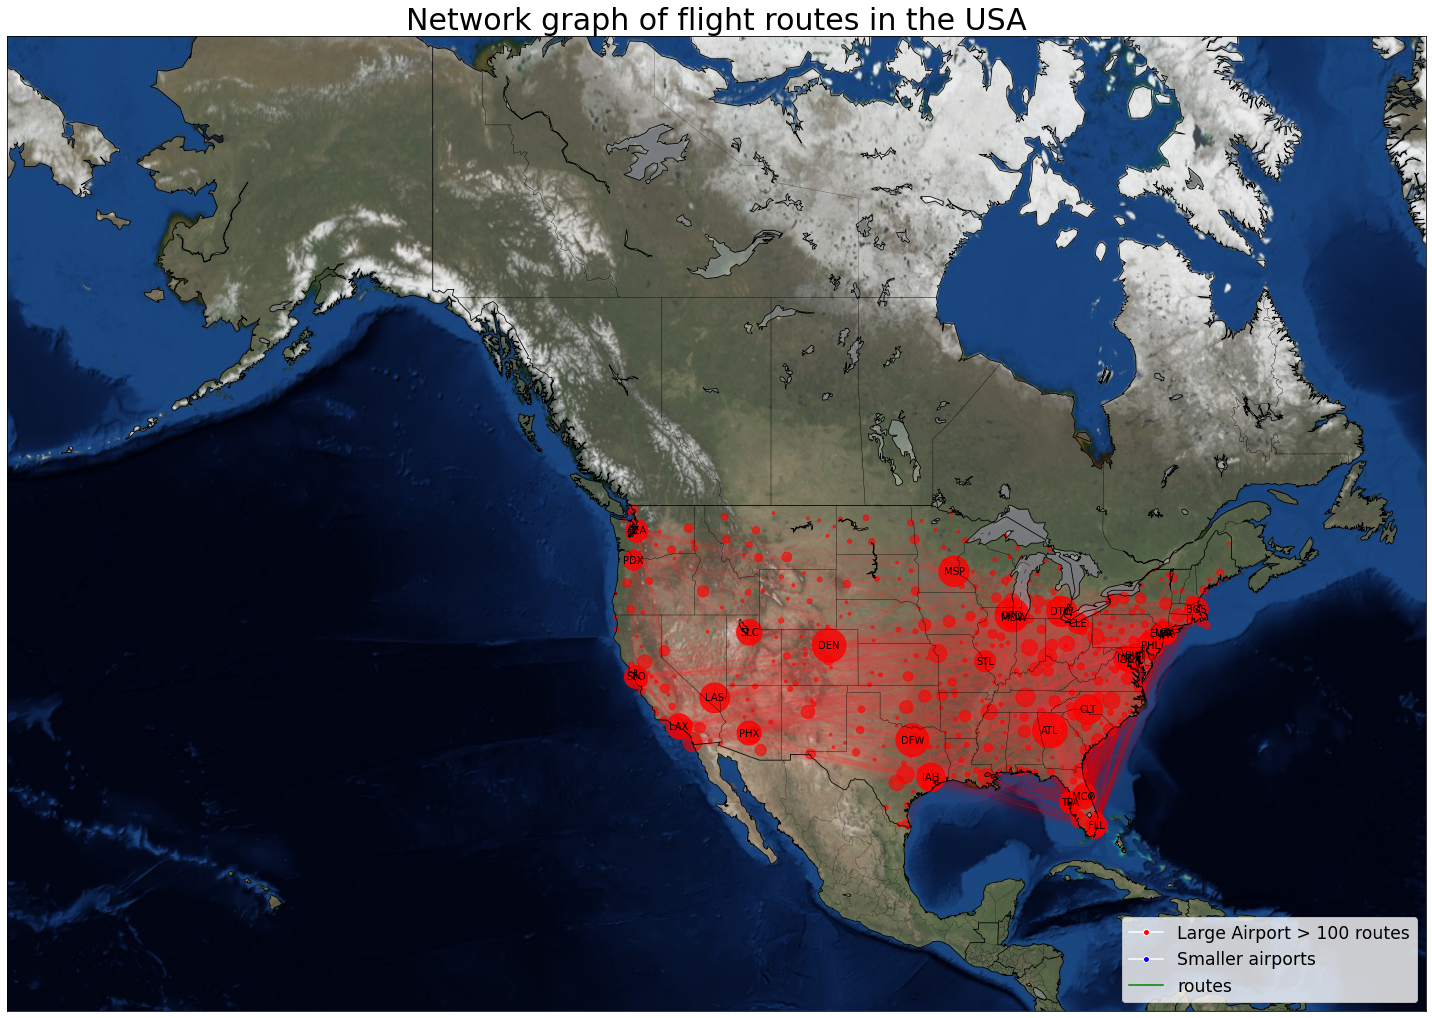

In [17]:
plt.figure(figsize = (20,25))
# 100이상 nodes
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 100],
    node_color = 'r',
    alpha = 0.8,
    node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 100])
# 100이상 labels
nx.draw_networkx_labels(
    G = graph,
    pos = pos,
    font_size=10,
    labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 100})
# 100이하 노드
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 100],
    node_color = 'r',
    alpha = 0.6,
    node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 100])
# edges
nx.draw_networkx_edges(
    G = graph,
    pos = pos,
    edge_color = 'r',
    width = routes_us['counts']*0.75, 
    alpha=0.06,
    arrows = False)

m.drawcountries(linewidth = 0.8)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth = 0.8)
m.fillcontinents(alpha = 0.3)

line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")

plt.legend((line1, line2, line3), ('Large Airport > 100 routes', 'Smaller airports', 'routes'), loc=4, fontsize = 'xx-large')

plt.title("Network graph of flight routes in the USA", fontsize = 30)
m.bluemarble()
plt.tight_layout()
plt.savefig("data/output/networkx_basemap3.png", format = "png", dpi = 300)
plt.show()

* DEN(덴버 국제 공항)과 같은 공항은 허브 역할을 하는것으로 보임
* 대부분의 대형 공항은 해안가, 동부에 위치